# Environmental impact of GPM precipitation features 

In [660]:
# Import libraries
import iris
import numpy as np
import pandas as pd
import os,sys
import matplotlib.pyplot as plt
import iris.plot as iplt
import iris.quickplot as qplt
import datetime
import urllib,zipfile,shutil
%matplotlib inline
# Import tobac itself
import tobac
from tobac import utils
import xarray as xr 
import glob


In [661]:
# import tracks for CNRR 
savedir='/media/juli/Data/third_pole/mcs_tracking/CNRR/Save'
file = savedir + '/Tracks_CNRR_2006_2016_updatedframes.h5'
#file = savedir + '/Tracks_CNRR_2006-2016_v_precip.h5'
Tracks = pd.read_hdf(file, 'table')
Tracks['timestr']=pd.to_datetime(Tracks['timestr'],format='%Y-%m-%d %H:%M:%S')

In [588]:
# import tracks for GPM 
savedir='/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/tobac/Save'
#file = savedir + '/Tracks_GPM_2014_2017_updatedframes.h5'
file = savedir + '/Tracks_GPM_2014-2017_v_precip.h5'
Tracks = pd.read_hdf(file, 'table')
Tracks['timestr']=pd.to_datetime(Tracks['timestr'],format='%Y-%m-%d %H:%M:%S')

In [611]:
# import tracks for GPM 
savedir='/media/juli/Data/third_pole/satellite_data/gpm_v06/Save'
file = savedir + '/Tracks_GPM_2006_2016.h5'
Tracks = pd.read_hdf(file, 'table')
Tracks['timestr']=pd.to_datetime(Tracks['timestr'],format='%Y-%m-%d %H:%M:%S')


In [605]:
## SEGMENT SELECTION 

# This function takes a time slot of the cell mask and a feature ID as an input and returns an index
# marking the entire region which belongs to cell in the specific timestep (this is needed), since
# the segmentation and cell masks still contain different feature IDs for one cloud object whereas
# only one feature is listed in the tracking dataframe

def select_segment(mask, f):
    import scipy.ndimage as ndi
    # labeling : each contiguous region is associated with an int
    labels, n = ndi.label(mask)

    x = np.where(mask== f)[0][0]
    y= np.where(mask == f)[1][0]
    new_label = labels[x,y]
    segment_i = labels == new_label

    return segment_i 


In [608]:
## UPDATE MASK 

# This function updates the segmentation mask and returns a cell mask where only areas which belong to cell
# segments are marked and all other identified features are removed. Takes feat_select as an input which are
# all the tracked features in tracking dataframe for a given time frame 

def update_mask(mask, feat_select):
    import scipy.ndimage as ndi

    for frame, xy in enumerate(mask):
        segments, n = ndi.label(xy)
        for i in np.unique(segments[segments > 0]):
            keep = 0 
            for f in xy[segments == i]:
                # if one of the features is in tracking dataframe, keep marked area 
                if f in feat_select.feature.values:
                    keep += 1
                else:
                    keep += 0
                    
            if keep == 0 :
                xy[segments == i] = 0
                mask[frame] = xy 
                
    return mask 


# calculations for tracks frame: 

- velocities
- total precip amount (obs, 30 min in GPM data!)
- contributions 
- max and mean rain rates 
- area 
- nearest neigbors 

## velocities

In [662]:
# calculate and save velocities 
Tracks = tobac.calculate_velocity(Tracks)
Tracks.to_hdf(savedir + '/Tracks_CNRR_2006-2016_v_precip.h5','table')

/home/juli/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:2377: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->datetime,key->block3_values] [items->['time']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [94]:
# calculate and save velocities 
Tracks = tobac.calculate_velocity(Tracks)
Tracks.to_hdf(savedir + '/Tracks_GPM_2014-2017_v_precip.h5','table')

## precip functions

In [278]:
def calculate_rain_impact(f, Tracks, gpm_dir, frames ,it):
    
    from netCDF4 import Dataset
    date= f[len(f)-9: len(f)-3]
    yearmonth= f[len(f)-9: len(f)-5] + '-' + f[len(f)-5: len(f)-3]
    print('calculating rain impact for.....', date)

    # read in data mask with segments for tracked cells 
    ds = Dataset(f)
    mask = np.array(ds['segmentation_mask'])  
    
    # select features for corresponding month in combined tracks 
    feat_select= Tracks.loc[Tracks['timestr'].dt.strftime('%Y-%m') == yearmonth]
    
    # read in corresponding precip file 
    file = gpm_dir + 'gpm_imerg_'+ date + '_tobac_input.nc4'
    #file = gpm_dir + 'cnrr_cnrr_'+date+'_TP.nc4.nc4'
    ds_precip= Dataset(file)
    precip = np.array(ds_precip['precipitationCal'])
    #precip = np.array(ds_precip['prcp'])
    precip[precip < 0.0 ] = 0 
    ds_precip.close()
    
    # update mask to include only precip from tracked features 
    for frame, values in enumerate(mask):
        frame_idx_table = frame + feat_select['frame'].values[0]
        frame_select =feat_select.loc[feat_select['frame'] == frame_idx_table]  # all tracked features in this time frame 
        frame_idx_mask= frame_idx_table  - frames  
            
        if frame_idx_mask < 0 :
            print('error in mask index calculation! --->', frame_idx_mask)
            break
        if frame_select.shape[0] != 0 and frame_idx_mask < np.shape(mask)[0]: 
            #print(frame_idx_table, frame_idx_mask)
            #if it < feat_select['frame'].values.shape[0] -2:
             #   it+= 1 

            timeframe= mask[frame_idx_mask, :, :] # timestep of frame with features  

            # test if segments in example also are linked features: 
            features = np.unique(timeframe[timeframe > 0])
            tracked_features = frame_select['feature'].values
            for f in features:
                if f not in tracked_features:
                    mask[frame_idx_mask, :, :][timeframe == f]= 0 

            values = mask[frame_idx_mask,:,:]
            # calculate total precip per system in new mask 
            timestamp= precip[frame_idx_mask, :, :]
            # update frame value 
            
            for v in np.unique(values[values > 0]):
                segment_i = select_segment(values, v )
                total_prec = np.nansum(timestamp[segment_i])
                
                # add values to track dataframe 
                for i in Tracks[Tracks['feature'] == v ].index:
                    Tracks.at[i, 'precip']= total_prec

    print('dataframe update for all features in ',str(yearmonth), 'frames:', frames, 'mask', np.shape(mask))
    if it == 0:
        frames += np.shape(mask)[0] - 1 
        it = 1 
    else:
        frames += np.shape(mask)[0]
        
    return Tracks, frames, it


In [273]:
def get_rainrates(f, Tracks, path, frames ,it):
    from netCDF4 import Dataset
    date= f[len(f)-9: len(f)-3]
    yearmonth= f[len(f)-9: len(f)-5] + '-' + f[len(f)-5: len(f)-3]
    print('get rain rates for.....', date)

    # read in cell mask 
    ds = Dataset(f)
    mask = np.array(ds['__xarray_dataarray_variable__'])  
    
    # read in corresponding file with rain rates 
    ##CNRR 
    file = gpm_dir + 'cnrr_cnrr_'+date+'_TP.nc4.nc4'
    ds_precip= Dataset(file)
    precip = np.array(ds_precip['prcp'])
    ## GPM 
    #file = gpm_dir + 'gpm_imerg_'+ date + '_tobac_input.nc4'
    #ds_precip= Dataset(file)
    #precip = np.array(ds_precip['precipitationCal'])
    precip[precip < 0.0 ] = 0 
    ds_precip.close()
    
    # select features for corresponding month in combined tracks 
    feat_select= Tracks.loc[Tracks['timestr'].dt.strftime('%Y-%m') == yearmonth]
    
    for frame, values in enumerate(mask):
        frame_idx_table = frame + feat_select['frame'].values[0]
        frame_select =feat_select.loc[feat_select['frame'] == frame_idx_table]  # all tracked features in this time frame 
        frame_idx_mask= frame_idx_table  - frames  
            
        if frame_idx_mask < 0 :
            print('error in mask index calculation! --->', frame_idx_mask)
            break
        if frame_select.shape[0] != 0 and frame_idx_mask < np.shape(mask)[0]: 
            
            features= mask[frame_idx_mask, :, :] # specific frame with tracked features
            precip_frame = precip[frame_idx_mask, :,:] # specific frame with rain rates 
            
            # extract max and mean rain rates 
            for f in np.unique(features[features > 0]):
                segment_i = select_segment(features, f )
                max_prec = np.nanmax(precip_frame[segment_i])
                mean_prec = np.nanmean(precip_frame[segment_i])

                # add values to track dataframe 
                for i in Tracks[Tracks['feature'] == f ].index:
                    Tracks.at[i, 'max_rr']= max_prec
                    Tracks.at[i, 'mean_rr']= mean_prec

    print('dataframe update for all features in ',str(yearmonth), 'frames:', frames, 'mask', np.shape(mask))
    if it == 0:
        frames += np.shape(mask)[0] - 1 
        it = 1 
    else:
        frames += np.shape(mask)[0]
        
    return Tracks, frames, it


In [612]:
feat_select= Tracks.loc[Tracks['timestr'].dt.strftime('%Y-%m') == '2010-03']
feat_select.frame.values[0]
#feat_select

72959

In [404]:
# calculate rain impact for GPM
import glob
# masks
savedir = '/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/tobac/Save'
file_list= glob.glob(savedir  + '/Mask_Segmentation_precip??????.nc')  
file_list.sort()
# precip data 
gpm_dir= '/media/juli/Data/third_pole/tobac/examples/climate-processes-tobac_example_data-b3e69ee/data/gpm/'


In [572]:
# calculate rain impact for CNRR 
import glob
# masks
file_list= glob.glob(savedir  + '/2006_2016/Mask_Segmentation_precip??????.nc')  
file_list.sort()
# precip data 
cnrr_dir= '/media/juli/Data/third_pole/CNRR/data/'
len(file_list)

132

In [9]:
# add new column 
Tracks  = Tracks.reindex( columns = Tracks.columns.tolist() + ['precip']) 

In [282]:
frames = 0 
it = 0 
path = cnrr_dir
path = gpm_dir
for f in file_list:
    Tracks, frames, it = calculate_rain_impact(f, Tracks, path, frames, it )
    

calculating rain impact for..... 201403
dataframe update for all features in  2014-03 frames: 0 mask (960, 351, 181)
calculating rain impact for..... 201404
dataframe update for all features in  2014-04 frames: 959 mask (1440, 351, 181)
calculating rain impact for..... 201405
dataframe update for all features in  2014-05 frames: 2399 mask (1488, 351, 181)
calculating rain impact for..... 201406
dataframe update for all features in  2014-06 frames: 3887 mask (1440, 351, 181)
calculating rain impact for..... 201407
dataframe update for all features in  2014-07 frames: 5327 mask (1488, 351, 181)
calculating rain impact for..... 201408
dataframe update for all features in  2014-08 frames: 6815 mask (1488, 351, 181)
calculating rain impact for..... 201409


SystemError: <built-in function is_scalar> returned a result with an error set

In [256]:
# RAIN RATES 

# cell masks
file_list= glob.glob(savedir  + '/Precip_cells??????.nc')  
file_list.sort()

# add new column 
Tracks  = Tracks.reindex( columns = Tracks.columns.tolist() + ['max_rr']) 
Tracks  = Tracks.reindex( columns = Tracks.columns.tolist() + ['mean_rr']) 

In [257]:
frames = 0 
it = 0 
path = cnrr_dir
for f in file_list:
    Tracks, frames, it = get_rainrates(f, Tracks, path, frames, it )
    


get rain rates for..... 200601
dataframe update for all features in  2006-01 frames: 0 mask (744, 141, 201)
get rain rates for..... 200602
dataframe update for all features in  2006-02 frames: 743 mask (672, 141, 201)
get rain rates for..... 200603
dataframe update for all features in  2006-03 frames: 1415 mask (744, 141, 201)
get rain rates for..... 200604
dataframe update for all features in  2006-04 frames: 2159 mask (720, 141, 201)
get rain rates for..... 200605
dataframe update for all features in  2006-05 frames: 2879 mask (744, 141, 201)
get rain rates for..... 200606
dataframe update for all features in  2006-06 frames: 3623 mask (720, 141, 201)
get rain rates for..... 200607
dataframe update for all features in  2006-07 frames: 4343 mask (744, 141, 201)
get rain rates for..... 200608
dataframe update for all features in  2006-08 frames: 5087 mask (744, 141, 201)
get rain rates for..... 200609
dataframe update for all features in  2006-09 frames: 5831 mask (720, 141, 201)
get r

dataframe update for all features in  2012-03 frames: 54023 mask (744, 141, 201)
get rain rates for..... 201204
dataframe update for all features in  2012-04 frames: 54767 mask (720, 141, 201)
get rain rates for..... 201205
dataframe update for all features in  2012-05 frames: 55487 mask (744, 141, 201)
get rain rates for..... 201206
dataframe update for all features in  2012-06 frames: 56231 mask (720, 141, 201)
get rain rates for..... 201207
dataframe update for all features in  2012-07 frames: 56951 mask (744, 141, 201)
get rain rates for..... 201208
dataframe update for all features in  2012-08 frames: 57695 mask (744, 141, 201)
get rain rates for..... 201209
dataframe update for all features in  2012-09 frames: 58439 mask (720, 141, 201)
get rain rates for..... 201210
dataframe update for all features in  2012-10 frames: 59159 mask (744, 141, 201)
get rain rates for..... 201211
dataframe update for all features in  2012-11 frames: 59903 mask (720, 141, 201)
get rain rates for.....

## save new tracks with calculated precip features

In [93]:
Tracks.to_hdf(savedir + '/Tracks_GPM_2014-2017_storms.h5','table')

/home/juli/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:2377: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->['time']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [269]:
Tracks.to_hdf(savedir + '/Tracks_CNRR_2006-2016_storms.h5','table')

## calculate area 

In [ ]:
mask_chunks= glob.glob(data_dir + '/Mask_Segmentation_precip??????.nc')  
mask_chunks.sort()


features = Tracks
for file in mask_chunks:
    print('calculating area for...', file)
    # read in  mask as iris cube 
    mask=iris.load_cube(file,'segmentation_mask')
    mask.attributes = None    
    features = tobac.calculate_area(features, mask, method_area= 'latlon')
    print('mean area for track features was...', np.nanmean(features.area.data))

## contributions 

In [650]:
# precip data 
gpm_dir= '/media/juli/Data/third_pole/tobac/examples/climate-processes-tobac_example_data-b3e69ee/data/gpm/'
cnrr_dir = '/media/juli/Data/third_pole/CNRR/data/'
gpm_dir = '/media/juli/Data/third_pole/satellite_data/gpm_v06/'

In [651]:
import glob
# masks 
file_list= glob.glob(savedir  + '/2006_2016/Mask_Segmentation_precip??????.nc')  
file_list.sort()

# dataframe to store total and system-related precip each month 
contributions= pd.DataFrame(columns=['date', 'total_precip','precip_1mm', 'prec_5mm',  'features_precip','tracked_precip', 'features_precip_5mm','tracked_precip_5mm','contr%tracked'])


In [652]:
def calculate_contributions(f, Tracks, path, contributions, frames):
    from netCDF4 import Dataset
    
    date= f[len(f)-9: len(f)-3]
    yearmonth= f[len(f)-9: len(f)-5] + '-' + f[len(f)-5: len(f)-3]
    # select features for corresponding month in combined tracks 
    feat_select= Tracks.loc[Tracks['timestr'].dt.strftime('%Y-%m') == yearmonth]

    # read in data mask 
    ds = Dataset(f)
    mask = np.array(ds['segmentation_mask'])  
    
    # read in corresponding precip file 
    file = gpm_dir + date[0:4] +  '/gpm_imerg_'+ date + '_tobac_input.nc4'
    ds_precip= Dataset(file)
    precip = np.array(ds_precip['precipitationCal'])
    #file = cnrr_dir + 'cnrr_cnrr_'+date+'_TP.nc4.nc4'
    #ds_precip= Dataset(file)
    #precip = np.array(ds_precip['prcp'])
    precip[precip < 0.0 ] = 0 
    ds_precip.close()

    # update mask 
    mask = update_mask(mask, feat_select)

    
    # calculate contributions
    prec= 0
    total_precip = 0 
    features_precip= 0 
    prec_1mm =0 
    prec_5mm = 0 
    tracked_prec_5mm = 0 
    features_precip_5mm = 0 
    mask_segments = np.array(ds['segmentation_mask'])  
    ds.close()
    for frame, values in enumerate(mask): 
        # total precip
        timestamp= precip[frame, :, :]
        total_precip += np.nansum(timestamp)
        prec_1mm += np.nansum(timestamp[timestamp >= 1]) 
        prec_5mm += np.nansum(timestamp[timestamp >= 5 ])  
        
        # precip related to features and mask 
        prec += np.nansum(timestamp[values > 0]) # tracked features
        mask_segment = mask_segments[frame,:,:]
        features_precip += np.nansum(timestamp[mask_segment > 0 ]) # identified features 
        
        timestamp[timestamp < 5] = 0 
        features_precip_5mm += np.nansum(timestamp[mask_segment > 0 ])
        tracked_prec_5mm += np.nansum(timestamp[values > 0])

    # add values to dataframe 
    contr = (prec/total_precip)*100
    #print('contribution of trajectory cells to total precip: '  ,  contr)
    if prec == 0:
        print('........but only contributions through non-linked precip features', file)
        contr= (features_precip/total_precip)*100
    
    data = [str(date), float(total_precip),float(prec_1mm), float(prec_5mm), float(features_precip), float(prec),float(features_precip_5mm), float(tracked_prec_5mm), float(contr)]
    contributions.loc[len(contributions)]= data
    print('contributions updated.')
    
    # save masked precipitation data (precip values of all trajectory cells)
    new_precip= xr.DataArray(mask)
    new_precip.to_netcdf(path=savedir + '/Precip_cells' + str(date) + '.nc')
    print('netcdf file saved.')
    # updated outer frame number 
    frames += (np.shape(mask)[0]) - 1
    
    return contributions, frames 



In [653]:
##########  for all chunks ############################################
frames = 0 
path = cnrr_dir 
path = gpm_dir
for f in file_list:
    print('calculating precip contributions for...', f)
    contributions_gpm, frames = calculate_contributions(f, Tracks, path, contributions, frames)

calculating precip contributions for... /media/juli/Data/third_pole/satellite_data/gpm_v06/Save/2006_2016/Mask_Segmentation_precip200601.nc
contributions updated.
netcdf file saved.
calculating precip contributions for... /media/juli/Data/third_pole/satellite_data/gpm_v06/Save/2006_2016/Mask_Segmentation_precip200602.nc
contributions updated.
netcdf file saved.
calculating precip contributions for... /media/juli/Data/third_pole/satellite_data/gpm_v06/Save/2006_2016/Mask_Segmentation_precip200603.nc
contributions updated.
netcdf file saved.
calculating precip contributions for... /media/juli/Data/third_pole/satellite_data/gpm_v06/Save/2006_2016/Mask_Segmentation_precip200604.nc
contributions updated.
netcdf file saved.
calculating precip contributions for... /media/juli/Data/third_pole/satellite_data/gpm_v06/Save/2006_2016/Mask_Segmentation_precip200605.nc
contributions updated.
netcdf file saved.
calculating precip contributions for... /media/juli/Data/third_pole/satellite_data/gpm_v06

contributions updated.
netcdf file saved.
calculating precip contributions for... /media/juli/Data/third_pole/satellite_data/gpm_v06/Save/2006_2016/Mask_Segmentation_precip200911.nc
contributions updated.
netcdf file saved.
calculating precip contributions for... /media/juli/Data/third_pole/satellite_data/gpm_v06/Save/2006_2016/Mask_Segmentation_precip200912.nc
contributions updated.
netcdf file saved.
calculating precip contributions for... /media/juli/Data/third_pole/satellite_data/gpm_v06/Save/2006_2016/Mask_Segmentation_precip201001.nc
contributions updated.
netcdf file saved.
calculating precip contributions for... /media/juli/Data/third_pole/satellite_data/gpm_v06/Save/2006_2016/Mask_Segmentation_precip201002.nc
contributions updated.
netcdf file saved.
calculating precip contributions for... /media/juli/Data/third_pole/satellite_data/gpm_v06/Save/2006_2016/Mask_Segmentation_precip201003.nc
contributions updated.
netcdf file saved.
calculating precip contributions for... /media/j

netcdf file saved.
calculating precip contributions for... /media/juli/Data/third_pole/satellite_data/gpm_v06/Save/2006_2016/Mask_Segmentation_precip201308.nc
contributions updated.
netcdf file saved.
calculating precip contributions for... /media/juli/Data/third_pole/satellite_data/gpm_v06/Save/2006_2016/Mask_Segmentation_precip201309.nc
contributions updated.
netcdf file saved.
calculating precip contributions for... /media/juli/Data/third_pole/satellite_data/gpm_v06/Save/2006_2016/Mask_Segmentation_precip201310.nc
contributions updated.
netcdf file saved.
calculating precip contributions for... /media/juli/Data/third_pole/satellite_data/gpm_v06/Save/2006_2016/Mask_Segmentation_precip201311.nc
contributions updated.
netcdf file saved.
calculating precip contributions for... /media/juli/Data/third_pole/satellite_data/gpm_v06/Save/2006_2016/Mask_Segmentation_precip201312.nc
contributions updated.
netcdf file saved.
calculating precip contributions for... /media/juli/Data/third_pole/sat

In [582]:
contributions_cnrr.to_hdf(savedir + '/contributions_cnrr_corrected.h5','table')

In [655]:
contributions_gpm.to_hdf(savedir + '/contributions_gpm_corrected.h5','table')

In [393]:
help(tobac.analysis.calculate_area)

Help on function calculate_area in module tobac.analysis:

calculate_area(features, mask, method_area=None)



In [659]:
contributions= contributions_cnrr
tracked_precip= contributions.tracked_precip.values
contr= contributions['contr%tracked'].values
total_precip= contributions.total_precip.values
features_precip= contributions.features_precip.values
prec_1mm =contributions.precip_1mm.values
prec_5mm= contributions.prec_5mm.values
features_precip_5mm =contributions.features_precip_5mm.values
tracked_precip_5mm= contributions.tracked_precip_5mm.values

contr_tracked = np.sum(tracked_precip)/np.sum(total_precip)
contr_features = np.sum(features_precip)/np.sum(total_precip)

contr_tracked_1mm = np.sum(tracked_precip)/np.sum(prec_1mm)
contr_features_1mm = np.sum(features_precip)/np.sum(prec_1mm)

contr_tracked_5mm = np.sum(tracked_precip_5mm)/np.sum(prec_5mm)
contr_features_5mm = np.sum(features_precip_5mm)/np.sum(prec_5mm)



print('features/total:',contr_features*100, 'tracked/total:',contr_tracked*100, 'tracked/1mm:',contr_tracked_1mm*100, 'features/1mm:',contr_features_1mm*100, 'tracked/5mm:',contr_tracked_5mm*100, 'features/5mm:',contr_features_5mm*100)

features/total: 58.25924417373488 tracked/total: 29.81430493974125 tracked/1mm: 39.523129739564915 features/1mm: 77.23096918279185 tracked/5mm: 49.71470393700792 features/5mm: 89.65732347246939


# Monthly means

In [594]:
contributions['date']=pd.to_datetime(contributions['date'],format='%Y%m')
months= []
for i in contributions.date:
    months.append(i.month)
    
contributions['month']= months

In [595]:
contributions.columns

Index(['date', 'total_precip', 'precip_1mm', 'prec_5mm', 'features_precip',
       'tracked_precip', 'features_precip_5mm', 'tracked_precip_5mm',
       'contr%tracked', 'month'],
      dtype='object')

In [596]:
means = contributions.groupby('month').mean()

tracked_precip= means.tracked_precip.values
features_precip= means.features_precip.values

total_precip= means.total_precip.values
precip_1mm =means.precip_1mm.values
precip_5mm =means.prec_5mm.values

tracked_precip_5mm= means.tracked_precip_5mm.values
features_precip_5mm= means.features_precip_5mm.values

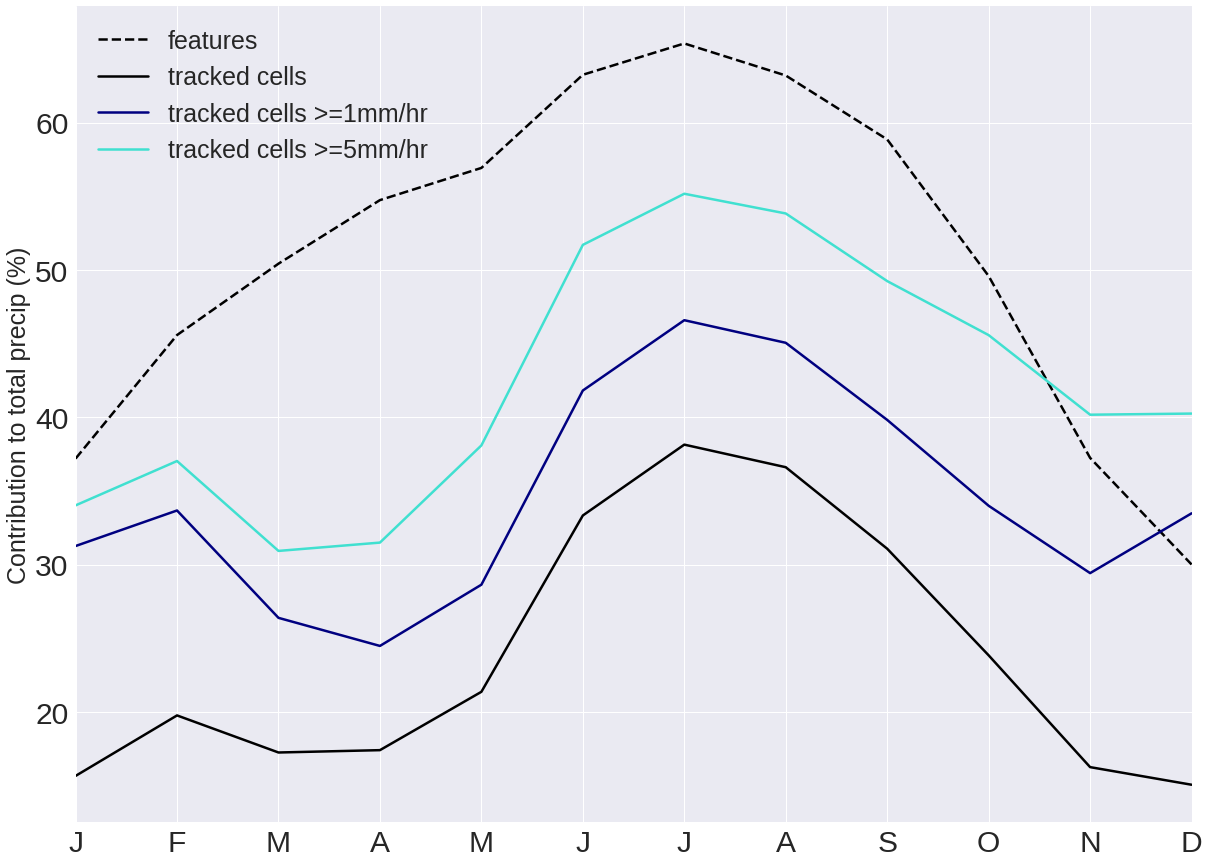

In [599]:
plt.style.use('seaborn')
plt.rcParams.update({'font.size': 30,
             'xtick.labelsize' : 30,
             'ytick.labelsize' : 30})
plt.figure(figsize=(20,15 ))

plt.plot(features_precip/total_precip*100, label= 'features', linestyle= '--', linewidth= 2.5, color = 'black')
plt.plot(tracked_precip/total_precip*100, label= 'tracked cells', linewidth= 2.5, color = 'black')

#plt.plot(features_precip/precip_1mm*100, label= 'features >=1mm/hr')
plt.plot(tracked_precip/precip_1mm*100, label= 'tracked cells >=1mm/hr', linewidth= 2.5, color = 'navy')

#plt.plot(features_precip_5mm/precip_5mm*100, label= 'features >=5mm/hr')
plt.plot(tracked_precip_5mm/precip_5mm*100, label= 'tracked cells >=5mm/hr', linewidth= 2.5, color = 'turquoise')


labels= ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
plt.xticks(np.arange(0,12,1), labels)

plt.xlim(0,11)
plt.legend(fontsize= 'small')
plt.ylabel('Contribution to total precip (%)', fontsize= '25')

# save figure to image file 
plt.savefig('/media/juli/Data/third_pole/mcs_tracking/tobac_plots/precip_contributions_cnrr.png')

# Track statistics 

In [ ]:
## create a new dataframe for tracked cells, which are possible mesoscale convective system candidates

# dataframe to store system stats 
mcs = pd.DataFrame(columns=['init_time', 'total_precip','mean_rr', 'max_rr', 'lifetime', 'v' , 'max_area', 'mean_area','total_area'])

cell = Tracks.groupby('cell')

# compute statistics 
init_time = cell.time.values[0]
total_precip = np.nansum(cell.total_precip.values)*0.5
mean_rr = np.nanmean(cell.mean_rr.values)
max_rr= np.nanmax(cell.max_rr.values)
lifetime = np.shape(cell)[0]*0.5
v= np.nanmean(cell.v.values)
#mean_area = np.nanmean(cell.area.values)
#max_area = np.nanmax(cell.area.values)
#total_area = np.nansum(cell.total_area) 


# add to dataframe 
data = [str(init_time), float(total_precip),float(mean_rr), float(max_rr), float(lifetime), float(v)]
mcs.loc[len(mcs)]= data




- add max rain rate 
- add area 
- calculations per track: lifetime, total precip, speed, intensity params



Comparison with CNRR: 
- choose largest impact events first 
- look for spatial and temporal coherence: 

- start from timestep of maturity (largest contiguous area) 
-> tracks available? 
-> define spatial search radius, track within that radius? 
-> define allowance for deviation from timespan and location 

In [102]:
Tracks[Tracks.cell ==9945]

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,longitude,latitude,ncells,cell,time_cell,precip,v
21393,2412,10,170.531573,5.614002,17,2,81,2014-05-01 06:30:00,2014-05-01 06:30:00,87.103160,27.511400,2,9945.0,00:00:00,8.133039,15.332797
21419,2413,8,170.088374,8.062029,13,7,107,2014-05-01 07:00:00,2014-05-01 07:00:00,87.058840,27.756203,120,9945.0,00:30:00,590.798645,17.515996
21437,2414,3,169.877220,5.235872,14,10,125,2014-05-01 07:30:00,2014-05-01 07:30:00,87.037724,27.473588,141,9945.0,01:00:00,1116.146240,15.872543
21463,2415,2,172.281620,3.810770,40,15,151,2014-05-01 08:00:00,2014-05-01 08:00:00,87.278162,27.331077,138,9945.0,01:30:00,2084.303223,2.559358
21490,2416,5,172.623344,3.529540,41,15,178,2014-05-01 08:30:00,2014-05-01 08:30:00,87.312333,27.302954,160,9945.0,02:00:00,2167.858643,5.126319
21521,2417,2,173.556134,3.540548,71,15,209,2014-05-01 09:00:00,2014-05-01 09:00:00,87.405611,27.304055,191,9945.0,02:30:00,2956.579346,19.224314
21549,2418,1,177.052789,3.640969,162,15,237,2014-05-01 09:30:00,2014-05-01 09:30:00,87.755279,27.314097,328,9945.0,03:00:00,7246.733398,13.276706
21573,2419,1,174.750205,2.992100,91,15,261,2014-05-01 10:00:00,2014-05-01 10:00:00,87.525022,27.249210,245,9945.0,03:30:00,3595.573730,8.091824
21598,2420,3,175.490814,1.861584,55,15,286,2014-05-01 10:30:00,2014-05-01 10:30:00,87.599084,27.136158,385,9945.0,04:00:00,3301.817383,4.602740
21628,2421,4,176.132171,1.384058,43,15,316,2014-05-01 11:00:00,2014-05-01 11:00:00,87.663218,27.088405,298,9945.0,04:30:00,2735.166748,17.864510


# Plot of the precipitation feature with the heaviest rain rate 

In [6]:
file = savedir+ '/Features_merged_nn.h5'
file = savedir+ '/Features_area201504.h5'
Features= pd.read_hdf(file, 'table')
Features['area']/= 1000000000
# equivalent radius 
#Features['eq_radius'] = np.roots(Features.area.values/ np.pi)

In [20]:
eq= np.sqrt(Features.area.values/ np.pi)

In [24]:
np.max(eq)
#np.mean(eq)

189.3616719924661

In [ ]:
max_precip = np.nanmax(Tracks.precip.values)
max_precip_10mm= np.nanmax(Tracks.loc[Tracks.threshold_value>= 10].precip.values)
Tracks.loc[Tracks.precip == max_precip_10mm]

In [ ]:
# read in netcdf precipitation file of time slot 

In [ ]:
# plot 

plt.figure(figsize=(20, 9))

#bounds= np.array([200, 205, 210, 215,220, 225, 230, 235, 240,245, 250 ])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors= 256)
cmap = plt.cm.get_cmap('twilight_shifted')

m = Basemap(projection='cyl', llcrnrlat=27.0,urcrnrlat=45.0, llcrnrlon=70.0, urcrnrlon=105.0,  resolution = 'c')

lon, lat =np.meshgrid(lons, lats)
xi,yi = m(lon,lat)
cs = m.pcolormesh(xi,yi, tbb,cmap=cmap, norm = norm)
cmap.set_under(color='black')
#cmap.set_bad(color='lightyellow')

# Plot TP boundary polyline from shapefile 
shapefile='/media/juli/Data/master_thesis/Master_thesis/data/DBATP/DBATP'
TP_bound=m.readshapefile(shapefile, 'boundary', color='black', linewidth=2.5)

xlabels=[70, 80, 90, 100]
ylabels= [ 27, 30, 35, 40, 45]

plt.xticks([70, 80,90, 100], xlabels, fontsize=25)
plt.yticks([27,30, 35, 40, 45],ylabels, fontsize=25)


plt.xlabel('Lon $^\circ$N',  fontsize=30)
plt.ylabel('Lat $^\circ$N',  fontsize=30)

cbar = plt.colorbar(extend= 'both')
cbar.set_label(' Rain rate (mm/hr)', fontsize= 30)
plt.tight_layout()

plt.savefig('/media/juli/Elements/comparison/example_tracked_precip_feature.png')


## CNRR vs. GPM number of tracks

In [95]:
Tracks[Tracks.ncells ==0 ].shape[0]

14908

In [94]:
Tracks.shape[0]

318955

In [93]:
Tracks[Tracks.ncells ==0 ].shape[0]/ Tracks.shape[0] * 100 

4.674013575582762

# about the same magnitude of tracks is found, but 5 vs. 10 years ! 


so probably CNRR does not capture major precip events! 